In [31]:
import sys
sys.path.append('../../')
import os 

import json
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.dates as dates

import matplotlib.pyplot as plt

from mpl_toolkits.basemap import Basemap
import geopandas as gpd

from src.utils import read_users

# Initialization

In [26]:
main_dir = '../../'
config_path = main_dir + 'config/config.json'

assert os.path.exists(config_path)

with open(config_path) as file:
        config = json.load(file)

plots_path = os.path.join(main_dir, config['plots_dir'])

In [4]:
all_user_dict = read_users(main_dir, config)

Reading user information files: ['users_2.json', 'users_1.json', 'users_0.json']


In [5]:
results_path = os.path.join(main_dir, config['results_dir'])
user_coords = {}
with open(os.path.join(results_path, f"{config['location_fname']}.json")) as json_file:
    user_coords = json.load(json_file) 

df_coord = pd.DataFrame.from_dict(user_coords, orient='index')

# Location Analysis

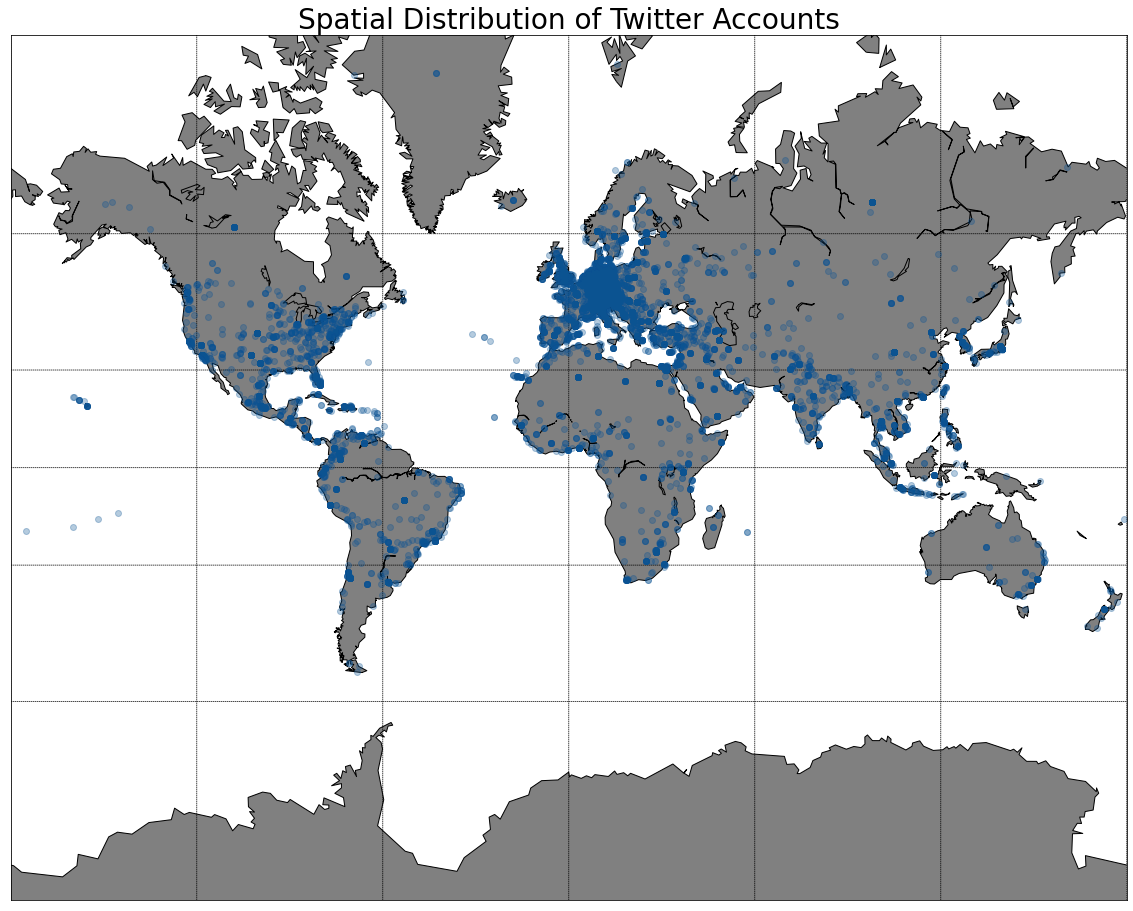

In [27]:
#Extract coords
lat = df_coord['lat'].values
lon = df_coord['lon'].values

# 1. map background global
fig = plt.figure(figsize=(20,20))
m = Basemap(projection='merc',llcrnrlat=-80,urcrnrlat=80,\
            llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')
m.drawcoastlines()
m.fillcontinents(color='grey',lake_color='grey', zorder=1)
m.drawparallels(np.arange(-90.,91.,30.))
m.drawmeridians(np.arange(-180.,181.,60.))

# 2. scatter tweet data
m.scatter(lon, lat, latlon=True, color='#0b5394', alpha=0.3, zorder=2)

plt.title(label="Spatial Distribution of Twitter Accounts", 
          fontsize=28)
fig.savefig(os.path.join(plots_path, 'spatial_distribution_users_all.png'))
plt.show()

In [7]:
count_german = len(df_coord[df_coord['country'] == 'Deutschland'])
print(f"German Account Ratio: {round(count_german/len(df_coord)*100,2)}%")

German Account Ratio: 65.92%


### QAnon Author Locations

In [12]:
tweets_path = os.path.join(main_dir, config['tweets_dir'])
with open(os.path.join(tweets_path, 'qanon_tweets.json')) as json_file:
    qanon_tweets = json.load(json_file)  

In [13]:
len(qanon_tweets)

26848

In [15]:
qanon_authors = []
for tweet_id in qanon_tweets.keys():
    tweet = qanon_tweets[tweet_id]
    qanon_authors.append(tweet['user']['id'])
    
print(f"Number of QAnon Authors: {len(set(qanon_authors))}")

Number of QAnon Authors: 2510


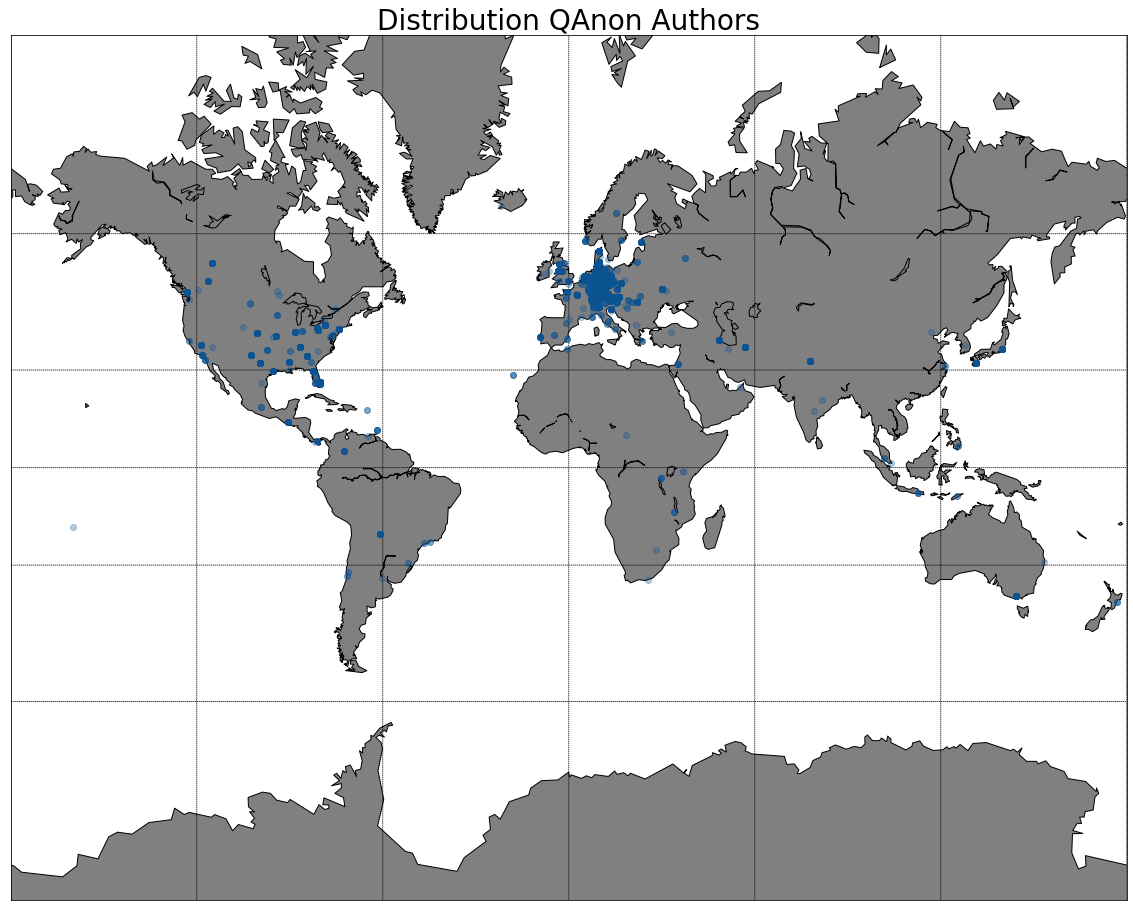

In [28]:
lon = []
lat = []
for user_id in qanon_authors:
    try:
        lon.append(user_coords[str(user_id)]['lon'])
        lat.append(user_coords[str(user_id)]['lat'])
    except:
        pass
        
# 1. map background global
fig = plt.figure(figsize=(20,20))
m = Basemap(projection='merc',llcrnrlat=-80,urcrnrlat=80,\
            llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')
m.drawcoastlines()
m.fillcontinents(color='grey',lake_color='grey', zorder=1)
m.drawparallels(np.arange(-90.,91.,30.))
m.drawmeridians(np.arange(-180.,181.,60.))


# 2. scatter tweet data
m.scatter(lon, lat, latlon=True, color='#0b5394', alpha=0.3, zorder=2)

plt.title(label="Distribution QAnon Authors", 
          fontsize=28)

fig.savefig(os.path.join(plots_path, 'spatial_distribution_users_qanon.png'))
plt.show()

# Creation Date Analysis

In [32]:
#extract all Twitter account creation dates
dates_list = []
dates_num = []
for user in all_user_dict:
    date_str = all_user_dict[user]['created_at']
    date = datetime.strptime(date_str, '%a %b %d %H:%M:%S %z %Y')
    dates_list.append(date)
    date_str = date.strftime("%Y-%b")
    dates_num.append(dates.datestr2num(date_str))
dates_num.sort()
dates_num.pop()

18555.0

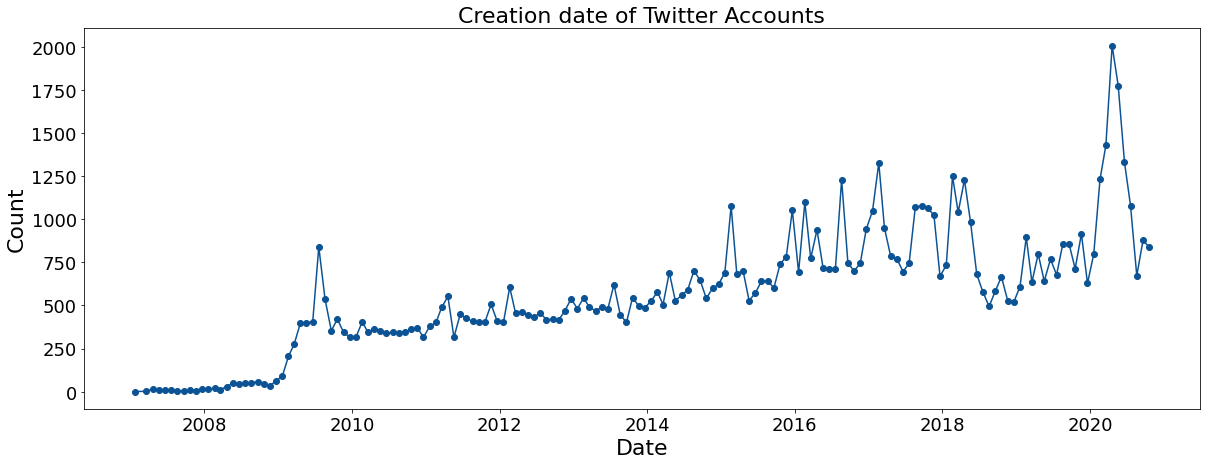

In [36]:
#plot account creation trend
histogram = np.histogram(np.asarray(dates_num), bins=np.unique(dates_num))
fig = plt.figure(figsize=(20,7))
plt.plot_date(histogram[1][1:], histogram[0], fmt="o-", tz=None, xdate=True,color='#0b5394')
plt.title("Creation date of Twitter Accounts", fontsize=22)
plt.xticks(fontsize=18)
plt.xlabel('Date',fontsize=22)
plt.ylabel('Count',fontsize=22)
plt.yticks(fontsize=18)

fig.savefig(os.path.join(plots_path, 'creation_date_trend.png'))
plt.show()

# Source Accounts Follower Analysis

In [50]:
#read all files in follower directory:
follower_path = os.path.join(main_dir, config['follower_dir'])
print(follower_path)
follower_file_list = os.listdir(follower_path)
follower_files = [filename for filename in follower_file_list if (filename.startswith(config['follower_fname']) and filename.endswith('.json'))]
print(f"Reading follower files: {follower_files}")

../../data/followers
Reading follower files: ['followers_TeamKenFM.json', 'followers_RT_Deutsch.json', 'followers_COMPACTMagazin.json']


In [54]:
#read follower lists into one dictionary with source account screen names as keys
follower_dict = {}
for filename in follower_files:
    filepath = os.path.join(follower_path, filename)
    print(filepath)
    screen_name = ('_').join(filename.split('_')[1:]).split('.')[0]
    with open(os.path.join(follower_path, filename))as fp:
        curr_dict = json.load(fp)
        assert len(curr_dict) == 1
        for key in curr_dict:
            follower_dict[screen_name] = curr_dict[key]

../../data/followers/followers_TeamKenFM.json
../../data/followers/followers_RT_Deutsch.json
../../data/followers/followers_COMPACTMagazin.json


Number of followers of TeamKenFM: 40169
Number of followers of RT_Deutsch: 48791
Number of followers of COMPACTMagazin: 29615


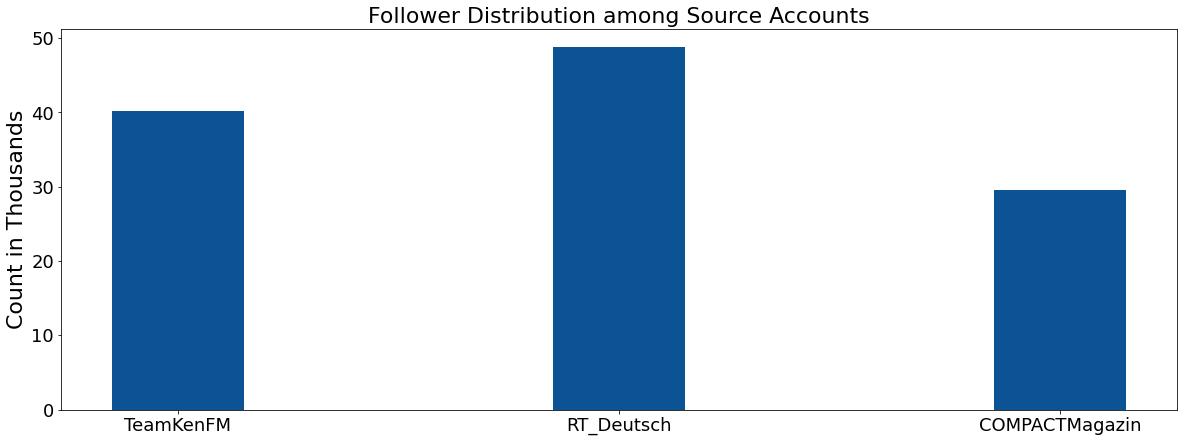

In [70]:
# plot follower distribution among source accounts
follower_count = []
screen_names = list(follower_dict.keys())
for key in follower_dict:
    print(f"Number of followers of {key}: {len(follower_dict[key])}")
    follower_count.append(len(follower_dict[key]))
    
fig = plt.figure(figsize=(20,7))
plt.bar(screen_names, np.asarray(follower_count)/1000,width=0.3, color='#0b5394')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Follower Distribution among Source Accounts',fontsize=22)
plt.ylabel("Count in Thousands", fontsize=22)

plot_path = os.path.join(main_dir, config['plots_dir'])
fig.savefig(os.path.join(plot_path, 'follower_distribution.png'))


In [65]:
screen_names = list(follower_dict.keys())
for i in range(len(screen_names)):
    for j in range(i+1,len(screen_names)):
        
        joined = follower_dict[screen_names[i]] +  follower_dict[screen_names[j]] 
        unique = len(set(joined))
        
        print(f"Overlap between {screen_names[i]} and {screen_names[j]}: {len(joined) -unique}")

Overlap between TeamKenFM and RT_Deutsch: 13728
Overlap between TeamKenFM and COMPACTMagazin: 7546
Overlap between RT_Deutsch and COMPACTMagazin: 8362
